In [1]:
import os
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
import numpy as np
import PIL
import keras

/home/prj201904037/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/prj201904037/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/prj201904037/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/prj201904037/miniconda3/lib/python3.7/site-packages/ten

In [2]:
#设置显卡使用情况和限制显存使用情况
# 指定第一块GPU可用 
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2" #Titan XP
config = tf.ConfigProto()  
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess = tf.Session(config=config)

In [61]:
#3层卷积
imgSize = 512  #图片尺寸
imgChan = 1    #1通道
kernelInit = 'uniform'  #卷积核初始化方式
nHiddenUnits = 50
maxpoolSize = (4,4)
nFilters = 100 #130 before 
kernelSize = (2,2)
inputStrides = 1
costFunction = 'categorical_crossentropy' #代价函数:不同于损失函数，代价函数在整个训练集上计算
early_stop_delta = 0.01 # 0.01 change or above is considered improvement
early_stop_patience = 10 

model=Sequential()

model.add(Conv2D(filters=nFilters, kernel_size = kernelSize ,strides= inputStrides,
                 input_shape=(imgSize,imgSize,3),kernel_initializer= kernelInit))
model.add(Activation('relu'))



model.add(MaxPooling2D(pool_size=maxpoolSize))


model.add(Conv2D(filters=nFilters, kernel_size = kernelSize ,strides= inputStrides,
                 kernel_initializer= kernelInit))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=maxpoolSize))


model.add(Conv2D(filters=nFilters, kernel_size = kernelSize ,strides= inputStrides,
                 kernel_initializer= kernelInit))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=maxpoolSize))

# model.add(Conv2D(filters=nFilters, kernel_size = kernelSize ,strides= inputStrides,
#                  kernel_initializer= kernelInit))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=maxpoolSize))


model.add(Flatten())
model.add(Dense(nHiddenUnits))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=early_stop_delta, patience=early_stop_patience, verbose=2, mode='auto')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 511, 511, 100)     1300      
_________________________________________________________________
activation_74 (Activation)   (None, 511, 511, 100)     0         
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 127, 127, 100)     0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 126, 126, 100)     40100     
_________________________________________________________________
activation_75 (Activation)   (None, 126, 126, 100)     0         
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 31, 31, 100)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 30, 30, 100)       40100     
__________

In [62]:
#测试 ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range = 40,     # 随机旋转度数
    width_shift_range = 0.2, # 随机水平平移
    height_shift_range = 0.2,# 随机竖直平移
    rescale = 1/255,         # 数据归一化
    shear_range = 20,       # 随机错切变换
    zoom_range = 0.2,        # 随机放大
    horizontal_flip = True,  # 水平翻转
    fill_mode = 'nearest',   # 填充方式
)
test_datagen = ImageDataGenerator(
    rescale = 1/255,         # 数据归一化
)

validation_datagen = ImageDataGenerator(
    rescale = 1/255,)


batch_size = 5
# 生成训练数据
train_generator = train_datagen.flow_from_directory(
    '../../data/imgProcessed/train_MandS',
    target_size=(imgSize,imgSize),
#     color_mode = "grayscale",
    batch_size=batch_size,
    class_mode='binary',
    )

#验证集
validation_generator = validation_datagen.flow_from_directory(
    '../../data/imgProcessed/validation_MandS',
    target_size=(imgSize,imgSize),
#     color_mode = "grayscale",
    batch_size=batch_size,
    class_mode='binary',
    )

Found 260 images belonging to 2 classes.
Found 23 images belonging to 2 classes.


In [63]:
train_generator.class_indices

{'no': 0, 'yes': 1}

In [64]:
model.compile(optimizer=Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-08),loss="binary_crossentropy",metrics=['binary_accuracy'])

In [68]:
from PIL import Image
history = model.fit_generator(train_generator,steps_per_epoch=len(train_generator),epochs=20,validation_data=validation_generator,validation_steps=len(validation_generator))

Epoch 1/20
52/52 [==============================] - 21s 413ms/step - loss: 0.0720 - binary_accuracy: 0.9769 - val_loss: 0.1403 - val_binary_accuracy: 0.9565
Epoch 2/20
52/52 [==============================] - 21s 397ms/step - loss: 0.0721 - binary_accuracy: 0.9769 - val_loss: 0.2036 - val_binary_accuracy: 0.9130
Epoch 3/20
52/52 [==============================] - 22s 426ms/step - loss: 0.0706 - binary_accuracy: 0.9769 - val_loss: 0.2991 - val_binary_accuracy: 0.8261
Epoch 4/20
52/52 [==============================] - 21s 399ms/step - loss: 0.0586 - binary_accuracy: 0.9808 - val_loss: 0.2448 - val_binary_accuracy: 0.9130
Epoch 5/20
52/52 [==============================] - 22s 425ms/step - loss: 0.0521 - binary_accuracy: 0.9769 - val_loss: 0.2252 - val_binary_accuracy: 0.9130
Epoch 6/20
52/52 [==============================] - 21s 410ms/step - loss: 0.0456 - binary_accuracy: 0.9923 - val_loss: 0.2511 - val_binary_accuracy: 0.8696
Epoch 7/20
52/52 [==============================] - 21s 40

In [37]:
model.save("../../model/MandS_Conv3_512_mp2by2_ker2by2_Adam_filter60_epoch10.h5")

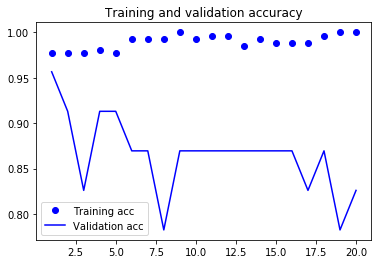

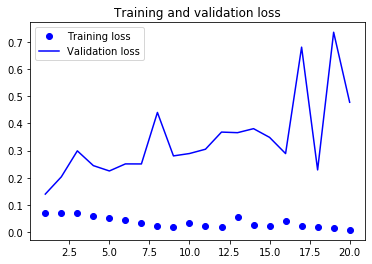

In [69]:
#画出结果
import matplotlib.pyplot as plt

#查看变量，发现history.history中就只有这四个值，分别是准确度，验证集准确度，损失，验证集损失
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#画两个图，分别是正确率和验证损失率
#正确率
plt.figure(1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('acc.png')
plt.show()
#损失
plt.figure(2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [70]:
#手动预测：
from PIL import ImageFilter
with open("../../data/imgProcessed/test_MandS/yes/names.txt") as file:
    for line in file.readlines():
        if line=="":
            break;
        img = Image.open("../../data/imgProcessed/test_MandS/yes/"+line.strip("\n"))
        img = img.resize((imgSize,imgSize),Image.ANTIALIAS)
        img = img.filter(ImageFilter.EDGE_ENHANCE)
        img = img.filter(ImageFilter.DETAIL)
        #img = img.filter(ImageFilter.RankFilter(5, 8))
        pred_value = model.predict(np.array(img).reshape((1,imgSize,imgSize,3))/255)[0]
        print("yes predicted as: ",'no'if pred_value<0.5 else 'yes')
        if(pred_value>=0.5):
            img.save(line.strip("\n"))
with open("../../data/imgProcessed/test_MandS/no/names.txt") as file:
    for line in file.readlines():
        if line=="":
            break;
        img = Image.open("../../data/imgProcessed/test_MandS/no/"+line.strip("\n"))
        img = img.resize((imgSize,imgSize),Image.ANTIALIAS)
        img = img.filter(ImageFilter.EDGE_ENHANCE)
        img = img.filter(ImageFilter.DETAIL)
        #img = img.filter(ImageFilter.RankFilter(5, 8))
        pred_value = model.predict(np.array(img).reshape((1,imgSize,imgSize,3))/255)[0]
        print("no predicted as: ",'no'if pred_value<0.5 else 'yes')
        if(pred_value<0.5):
            img.save(line.strip("\n"))

yes predicted as:  no
yes predicted as:  yes
yes predicted as:  no
yes predicted as:  yes
yes predicted as:  no
yes predicted as:  yes
yes predicted as:  yes
no predicted as:  no
no predicted as:  no
no predicted as:  no
no predicted as:  no
no predicted as:  no
no predicted as:  no
no predicted as:  no
no predicted as:  no
no predicted as:  no
no predicted as:  no
